In [4]:
import os
import random
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import time
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
# Global configuration and hyperparameters for MFCC extraction and model training
DATASET_PATH = './Language Detection Dataset'
LANGUAGES = ['Bengali','Gujarati','Malayalam','Hindi', 'Marathi', 'Kannada','Punjabi','Tamil','Telugu','Urdu']  # Folder names for the languages
SAMPLE_RATE = 16000
N_MFCC = 40

BATCH_SIZE = 64
hidden_dim = 225
learning_rate = 1e-4

NUM_EPOCHS = 50

In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

In [8]:
###########################
#  MFCC Extraction & Utils
###########################

def extract_mfcc(file_path, resample_waveform=True, target_sample_rate=SAMPLE_RATE, n_mfcc=N_MFCC):
    """
    Extracts MFCC features from an audio file.
    
    Parameters:
        file_path (str): Path to the audio file.
        resample_waveform (bool): If True, resample the waveform to target_sample_rate.
                                   If False, use the original sample rate.
        target_sample_rate (int): The sample rate to use if resampling.
        n_mfcc (int): Number of MFCC coefficients.
        
    Returns:
        torch.Tensor: MFCC tensor of shape (n_mfcc, time_frames) or None if extraction fails.
    """
    try:
        waveform, sr = torchaudio.load(file_path)
        # Always move waveform to device for consistency
        waveform = waveform
        if resample_waveform and sr != target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sample_rate)
            waveform = resampler(waveform)
            used_sr = target_sample_rate
            # print(f"Resampled from {sr} to {target_sample_rate}")
        else:
            used_sr = sr  # Use the original sample rate
            # print(f"Original sample rate: {sr}")
            
        
        # If stereo, convert to mono by taking the first channel
        if waveform.shape[0] > 1:
            waveform = waveform[0].unsqueeze(0) # Shape: (1, time_frames)
            
        # Define MFCC transform.
        # Note: When not resampling, we use the original sample rate in the transform.
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=used_sr,
            n_mfcc=n_mfcc,
            melkwargs={
                'n_fft': 1024,
                'n_mels': 40,   # Adjusted to avoid warnings about all-zero filters
                'hop_length': 512
            }
        )
        
        mfcc = mfcc_transform(waveform)
        # print(mfcc.device)
        return mfcc.squeeze(0)  # Shape: (n_mfcc, time_frames)
    except Exception as e:
        # print(f"Error processing {file_path}")
        return None

def get_audio_files(dataset_path, language):
    """
    Returns a list of file paths for audio files in the specified language folder.
    """
    language_folder = os.path.join(dataset_path, language)
    files = [os.path.join(language_folder, f) for f in os.listdir(language_folder) if f.endswith('.mp3')]
    return files

def visualize_mfcc(mfcc_tensor, title):
    """
    Visualizes an MFCC spectrogram given an MFCC tensor.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(mfcc_tensor.numpy(), aspect='auto', origin='lower')
    plt.title(title)
    plt.ylabel('MFCC Coefficients')
    plt.xlabel('Time Frames')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def compute_statistics(mfcc_list):
    """
    Computes the per-coefficient mean and variance from a list of MFCC tensors.
    """
    concatenated = torch.cat(mfcc_list, dim=1)  # shape: (n_mfcc, total_time_frames)
    mean = concatenated.mean(dim=1)
    var = concatenated.var(dim=1)
    return mean, var

In [9]:
###############################
#  Dataset and Model Classes
###############################

class LanguageDataset(Dataset):
    def __init__(self, features, labels):
        """
        features: list or numpy array of 1D arrays (MFCC features averaged over time)
        labels: list or numpy array of integer labels
        """
        self.features = [torch.tensor(f, dtype=torch.float32) for f in features]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class MFCCClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MFCCClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
#########################################
# EarlyStopping Class
#########################################
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=5, min_delta=0.001, path='best_model.pt', verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.verbose = verbose
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print("Validation loss decreased. Saving model...")
        torch.save(model.state_dict(), self.path)

In [11]:
from collections import defaultdict

In [12]:
# Containers for Task A (Comparative Analysis)
analysis_mfccs = defaultdict(list)

# Containers for Task B (Classification)
classification_features = []  # Averaged MFCC features (1D vector)
classification_labels = []    # Numeric labels corresponding to languages
mfcc_lang_analysis=defaultdict(list)  # For storing MFCCs for each language

In [13]:
# Define the path where the analysis_mfccs will be stored
am_cache_file = 'analysis_mfccs_compressed.pkl'
mla_cache_file = 'mfcc_lang_analysis_compressed.pkl'

In [14]:
# --- Task A: MFCC Extraction, Visualization, and Statistical Analysis ---
# Loop through languages
# Check if the file exists
# if os.path.exists(am_cache_file) :
# and os.path.exists(mla_cache_file):
#     print("Loading pre-computed MFCCs from disk...")
#     # Load the pre-computed MFCCs
#     analysis_mfccs = joblib.load(am_cache_file)
#     print("Loaded analysis_mfccs from file.")
    
#     mfcc_lang_analysis = joblib.load(mla_cache_file)
#     print("Loaded mfcc_lang_analysis from file.")
# else:
for lang_idx, language in enumerate(LANGUAGES):
    print(f"\nProcessing language: {language}")
    files = get_audio_files(DATASET_PATH, language)
    print(f"Found {len(files)} files for language: {language}")
    
    analysis_valid_count = 0
    classification_valid_count = 0
    
    # Process each file for both analysis and classification
    for file_path in files:
        # Task A: Use original waveform (no resampling)
        mfcc_analysis = extract_mfcc(file_path, resample_waveform=False)
        if mfcc_analysis is not None:
            mfcc_lang_analysis[language].append(mfcc_analysis)
            analysis_valid_count += 1

        # Task B: Use uniform (resampled) waveform for classification
        mfcc_class = extract_mfcc(file_path, resample_waveform=True)
        if mfcc_class is not None:
            analysis_mfccs[language].append(mfcc_class)
            # Average over time to get a fixed-length vector
            mfcc_avg = mfcc_class.mean(dim=1).numpy()  # shape: (n_mfcc,)
            classification_features.append(mfcc_avg)
            classification_labels.append(lang_idx)
            classification_valid_count += 1    

    print(f"Successfully processed {analysis_valid_count} valid files for analysis in {language}")
    print(f"Successfully processed {classification_valid_count} valid files for classification in {language}")

    # # Save the computed MFCCs to disk
    # joblib.dump(analysis_mfccs, am_cache_file, compress=3)
    # print("Saved analysis_mfccs to file.")

    #     # Save the computed MFCCs to disk
    # joblib.dump(mfcc_lang_analysis, mla_cache_file, compress=3)
    # print("Saved mfcc_lang_analysis to file.")   
    


Processing language: Bengali
Found 27258 files for language: Bengali
Successfully processed 27237 valid files for analysis in Bengali
Successfully processed 27237 valid files for classification in Bengali

Processing language: Gujarati
Found 26441 files for language: Gujarati
Successfully processed 26392 valid files for analysis in Gujarati
Successfully processed 26387 valid files for classification in Gujarati

Processing language: Malayalam
Found 24044 files for language: Malayalam
Successfully processed 24040 valid files for analysis in Malayalam
Successfully processed 24039 valid files for classification in Malayalam

Processing language: Hindi
Found 25462 files for language: Hindi
Successfully processed 25447 valid files for analysis in Hindi
Successfully processed 25447 valid files for classification in Hindi

Processing language: Marathi
Found 25379 files for language: Marathi
Successfully processed 25311 valid files for analysis in Marathi
Successfully processed 25309 valid fi

Selected languages for visualization: ['Gujarati', 'Bengali', 'Marathi', 'Urdu']


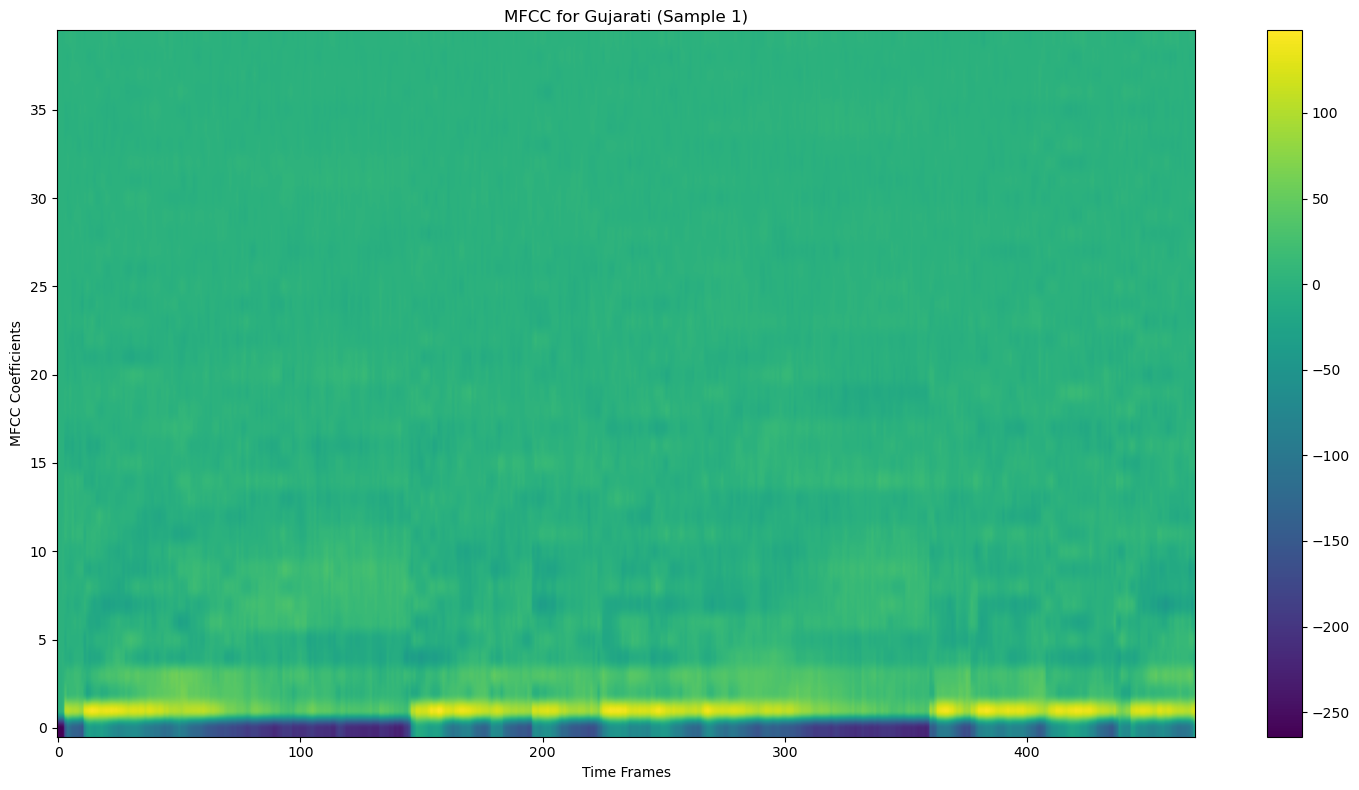

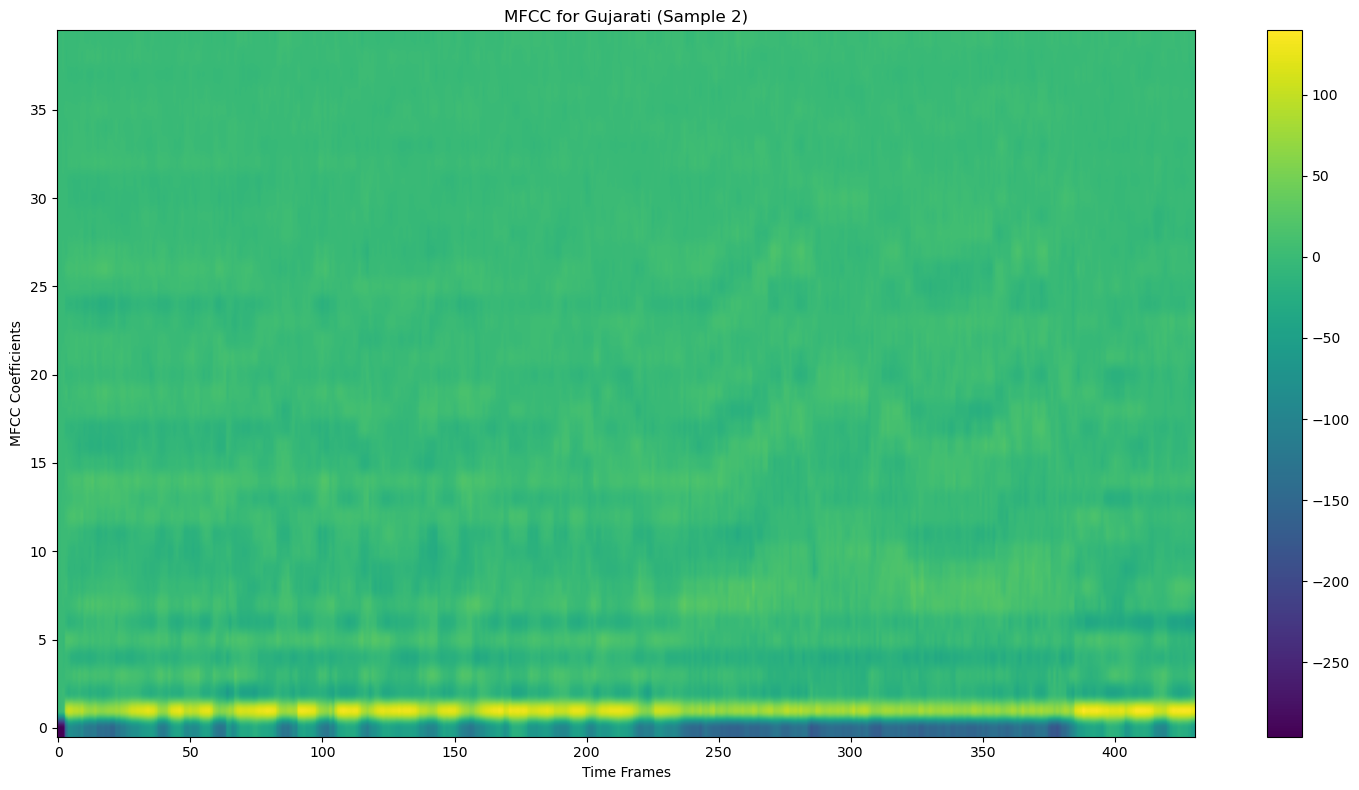

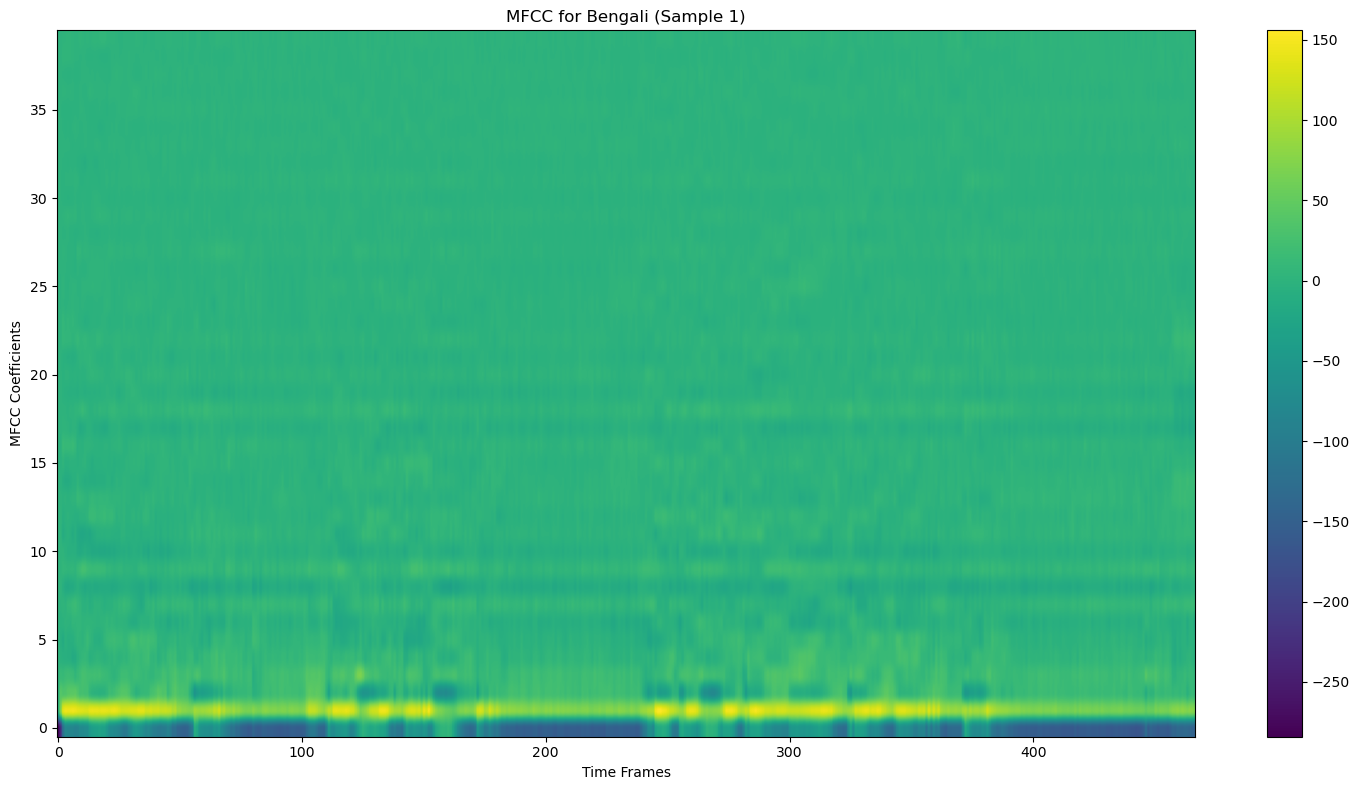

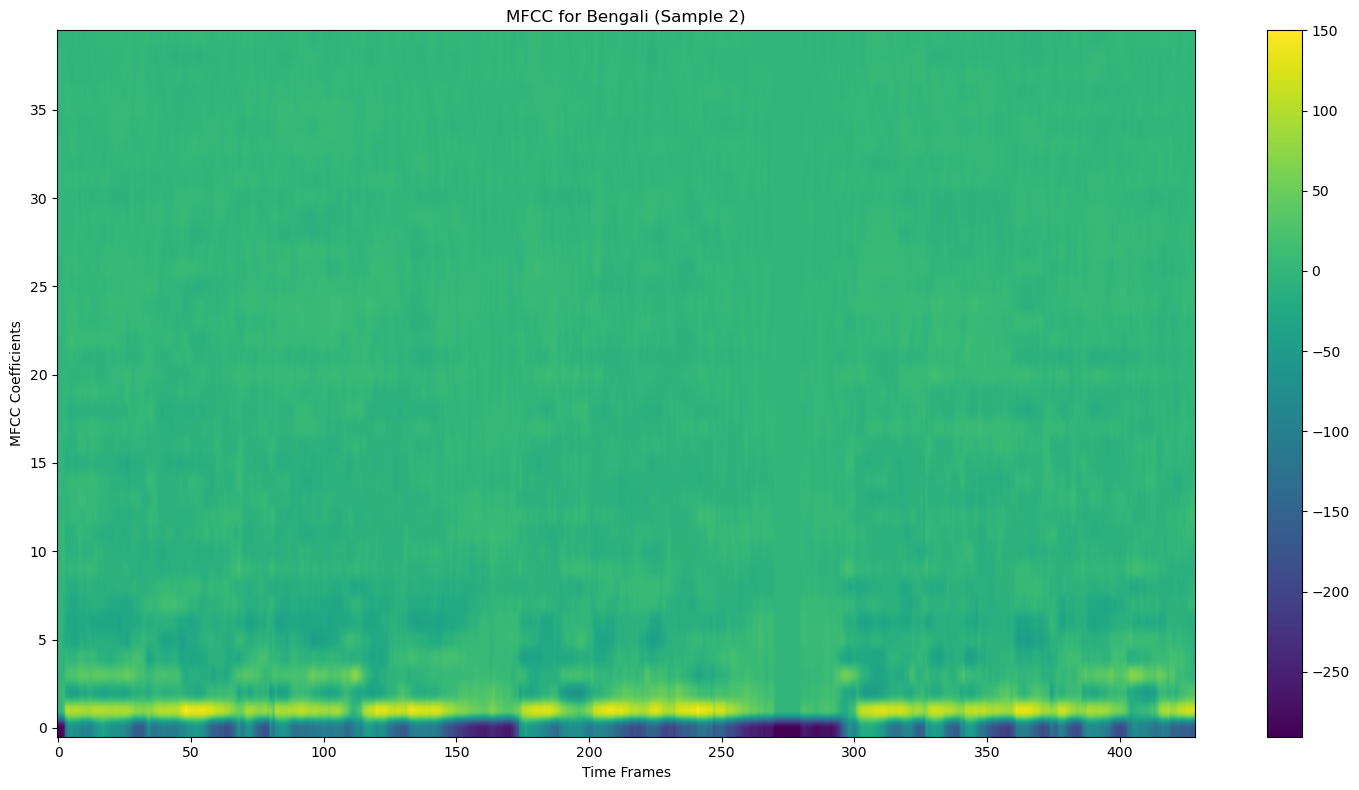

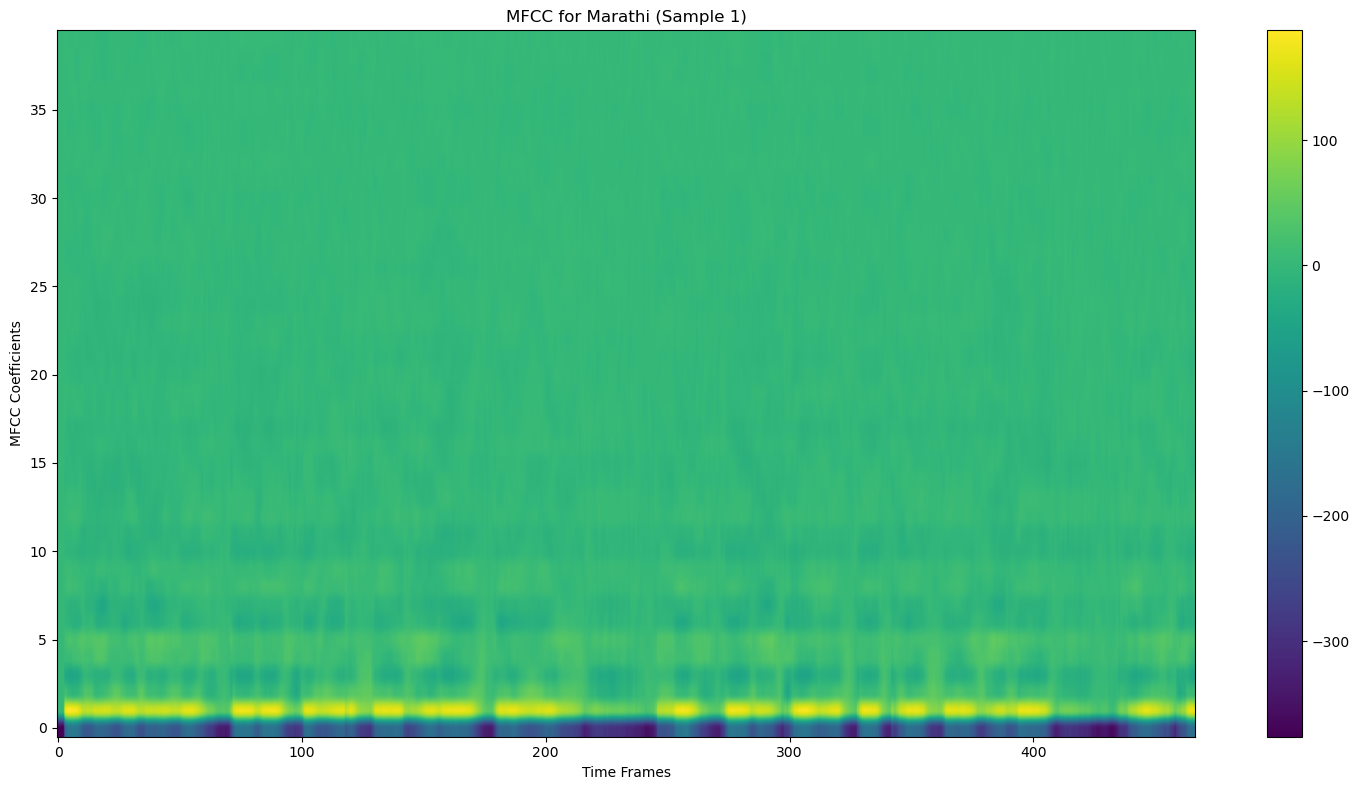

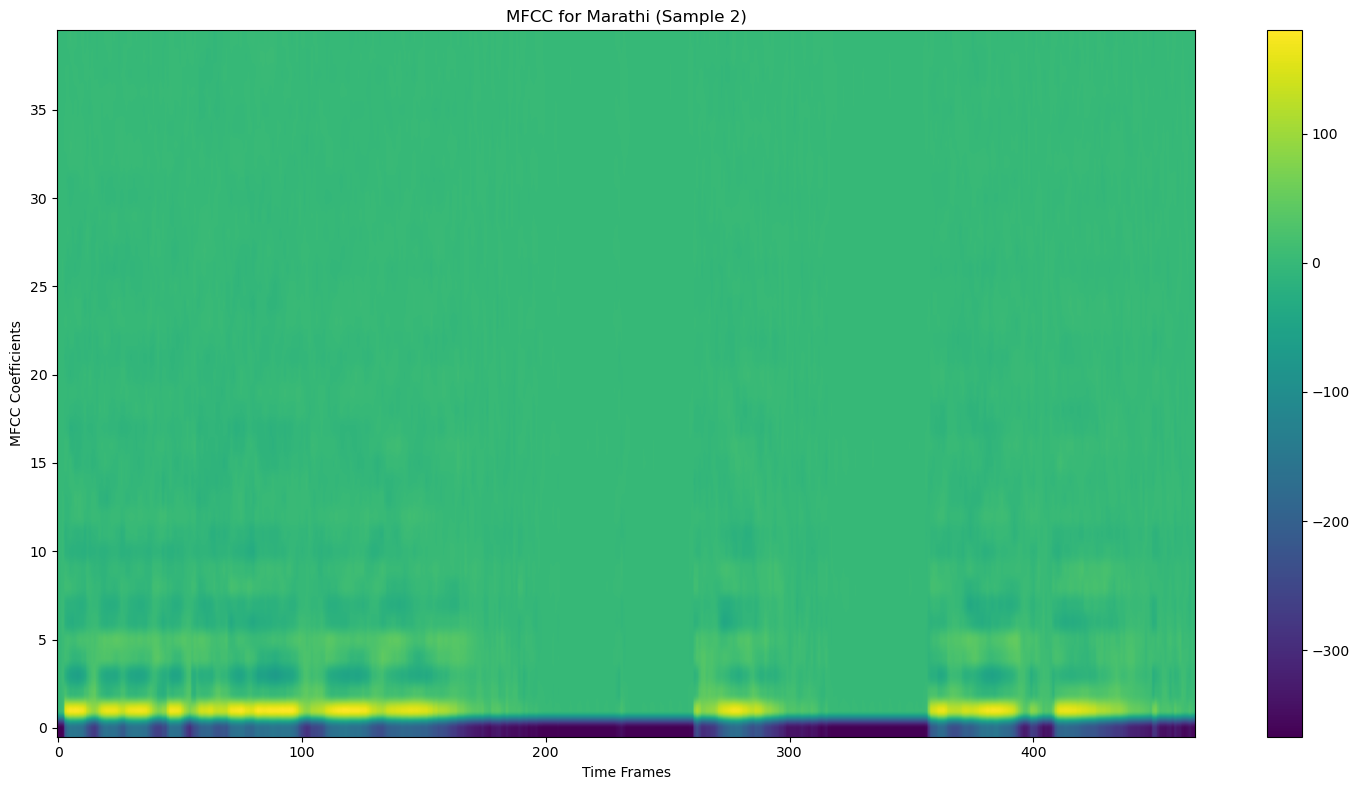

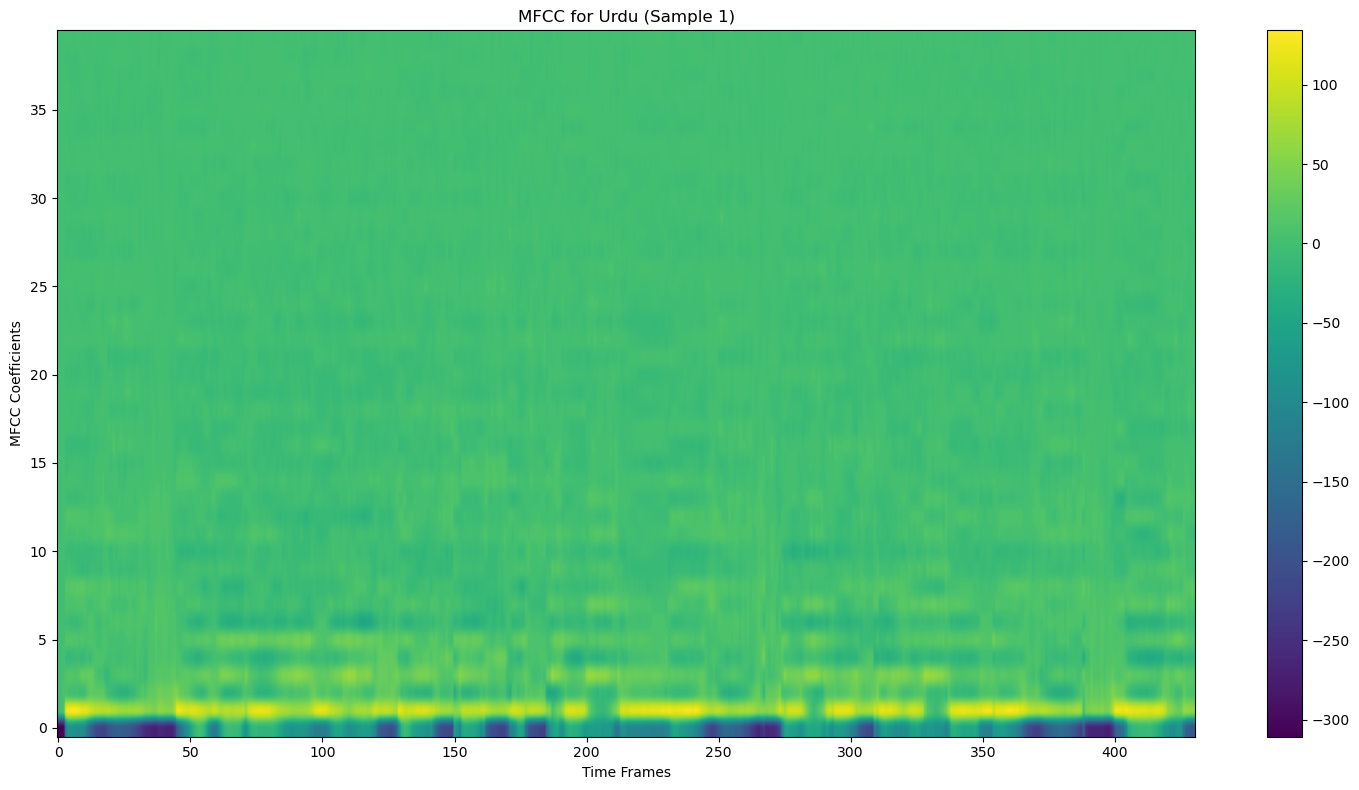

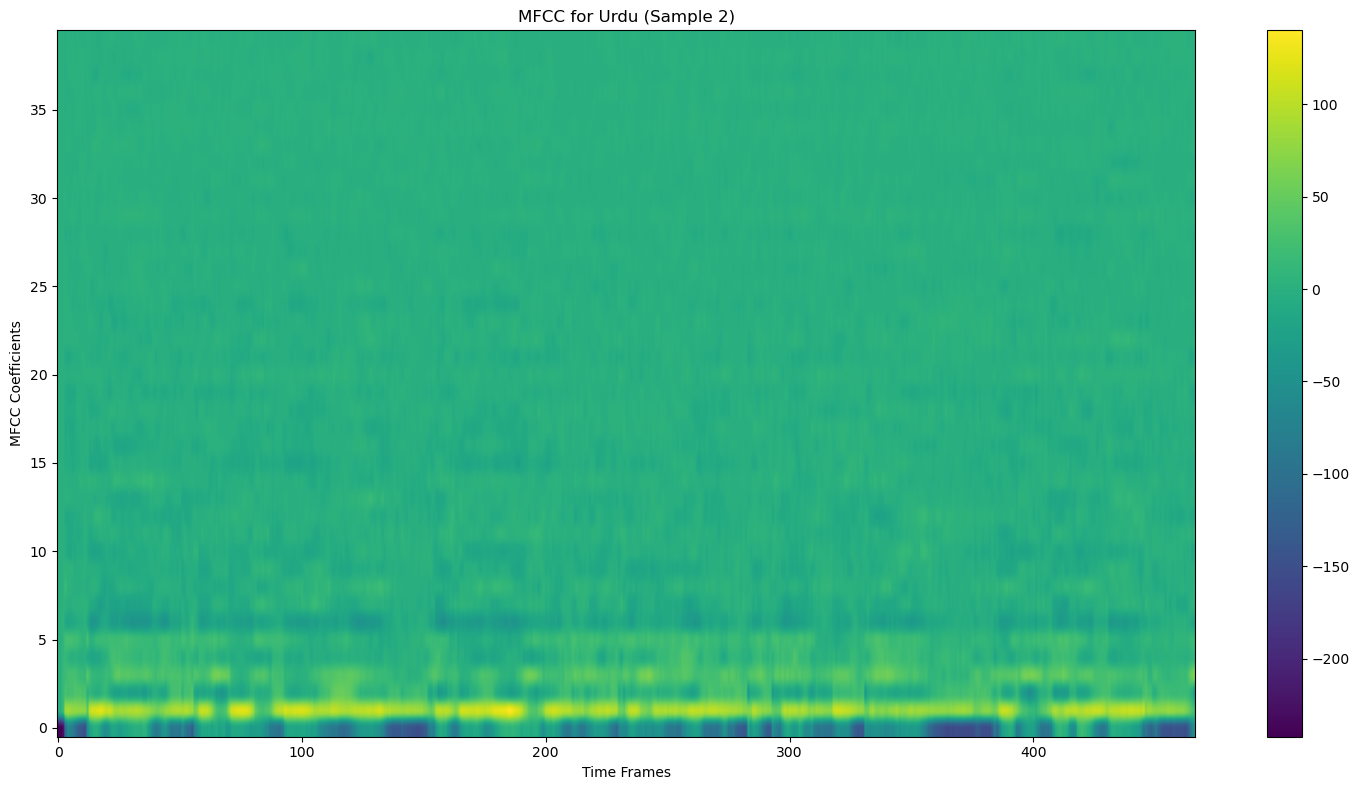

In [15]:
# Randomly pick any 4 languages and plot random 2 MFCCs for each selected language for visualization
selected_languages = random.sample(LANGUAGES, 4)
print(f"Selected languages for visualization: {selected_languages}")
for language in selected_languages:
    if language in mfcc_lang_analysis:
        mfccs = mfcc_lang_analysis[language]
        for i in range(2):  # Plot 2 random MFCCs for each selected language
            mfcc_tensor = random.choice(mfccs)
            visualize_mfcc(mfcc_tensor, f"MFCC for {language} (Sample {i+1})")
    else:
        print(f"No MFCC data available for {language}.")


In [16]:
import seaborn as sns
import pandas as pd

# Assuming analysis_mfccs is a dictionary with keys as language names and values as lists of MFCC tensors.
# Compute statistics (mean and variance) for each language
analysis_stats = {}
for language, mfcc_list in analysis_mfccs.items():
    if mfcc_list:  # Ensure there are valid samples
        mean, var = compute_statistics(mfcc_list)
        # Convert to numpy arrays for plotting
        analysis_stats[language] = (mean.numpy(), var.numpy())

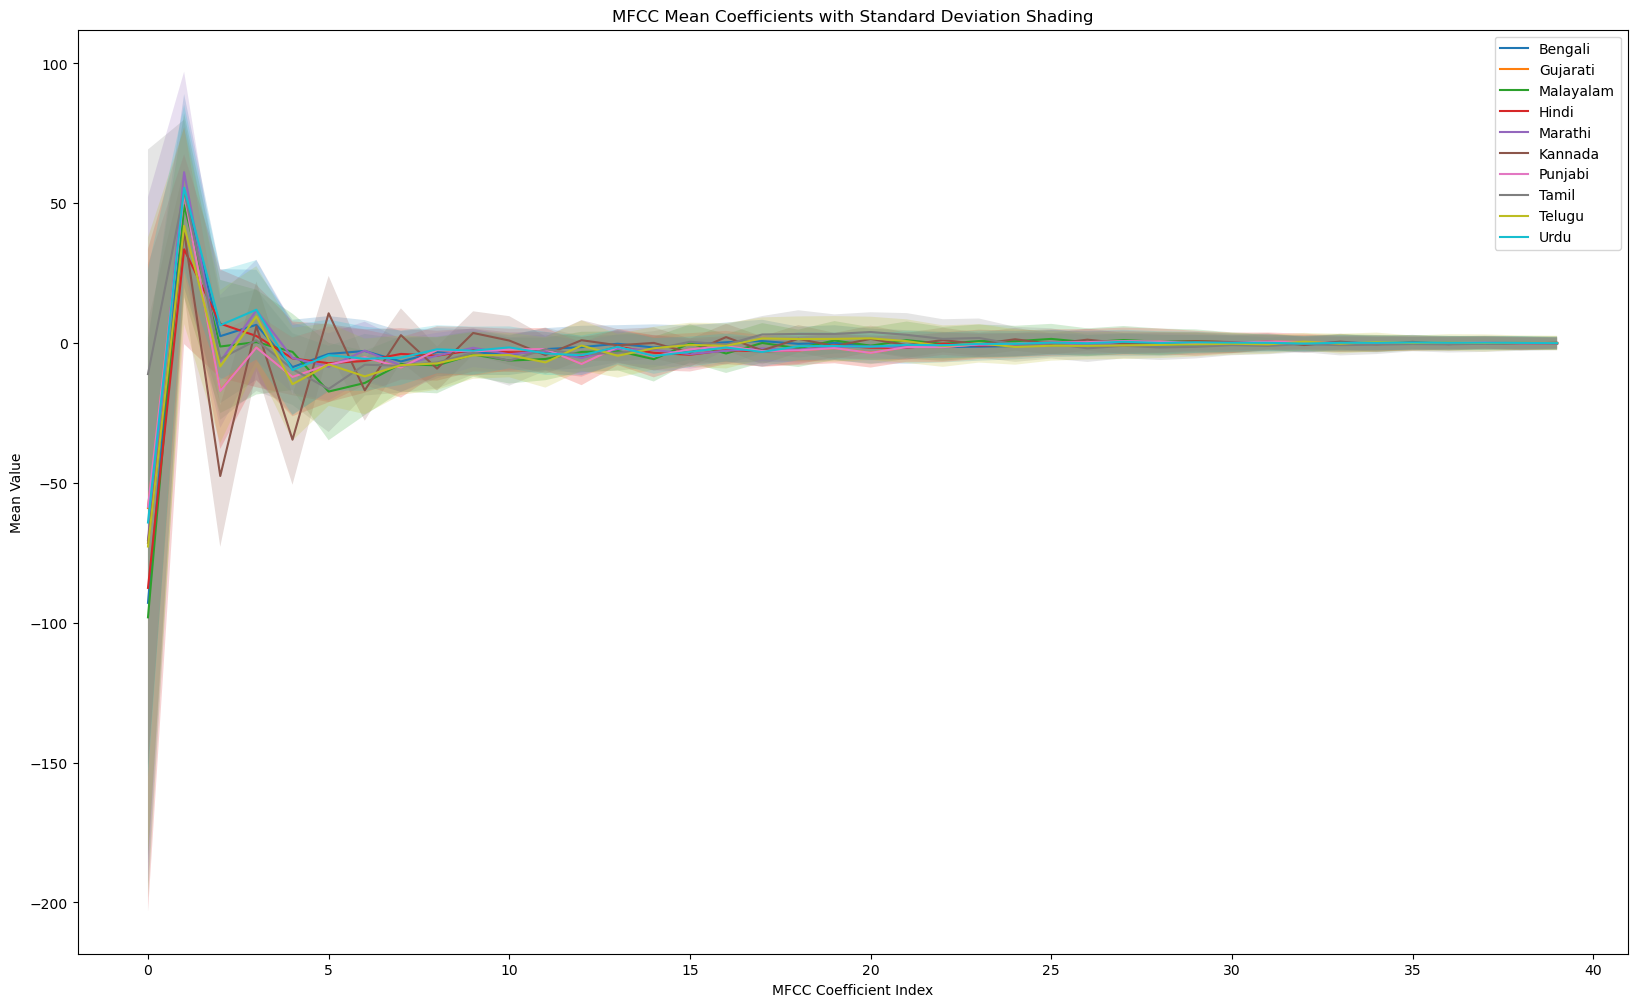

In [17]:
# 1. Line Plot with Shaded Variance
plt.figure(figsize=(20, 12))
for language, (mean, var) in analysis_stats.items():
    x = np.arange(len(mean))
    plt.plot(x, mean, label=language)
    # Use the square root of variance to approximate standard deviation
    plt.fill_between(x, mean - np.sqrt(var), mean + np.sqrt(var), alpha=0.2)
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Mean Value')
plt.title('MFCC Mean Coefficients with Standard Deviation Shading')
plt.legend()
plt.show()
plt.close()

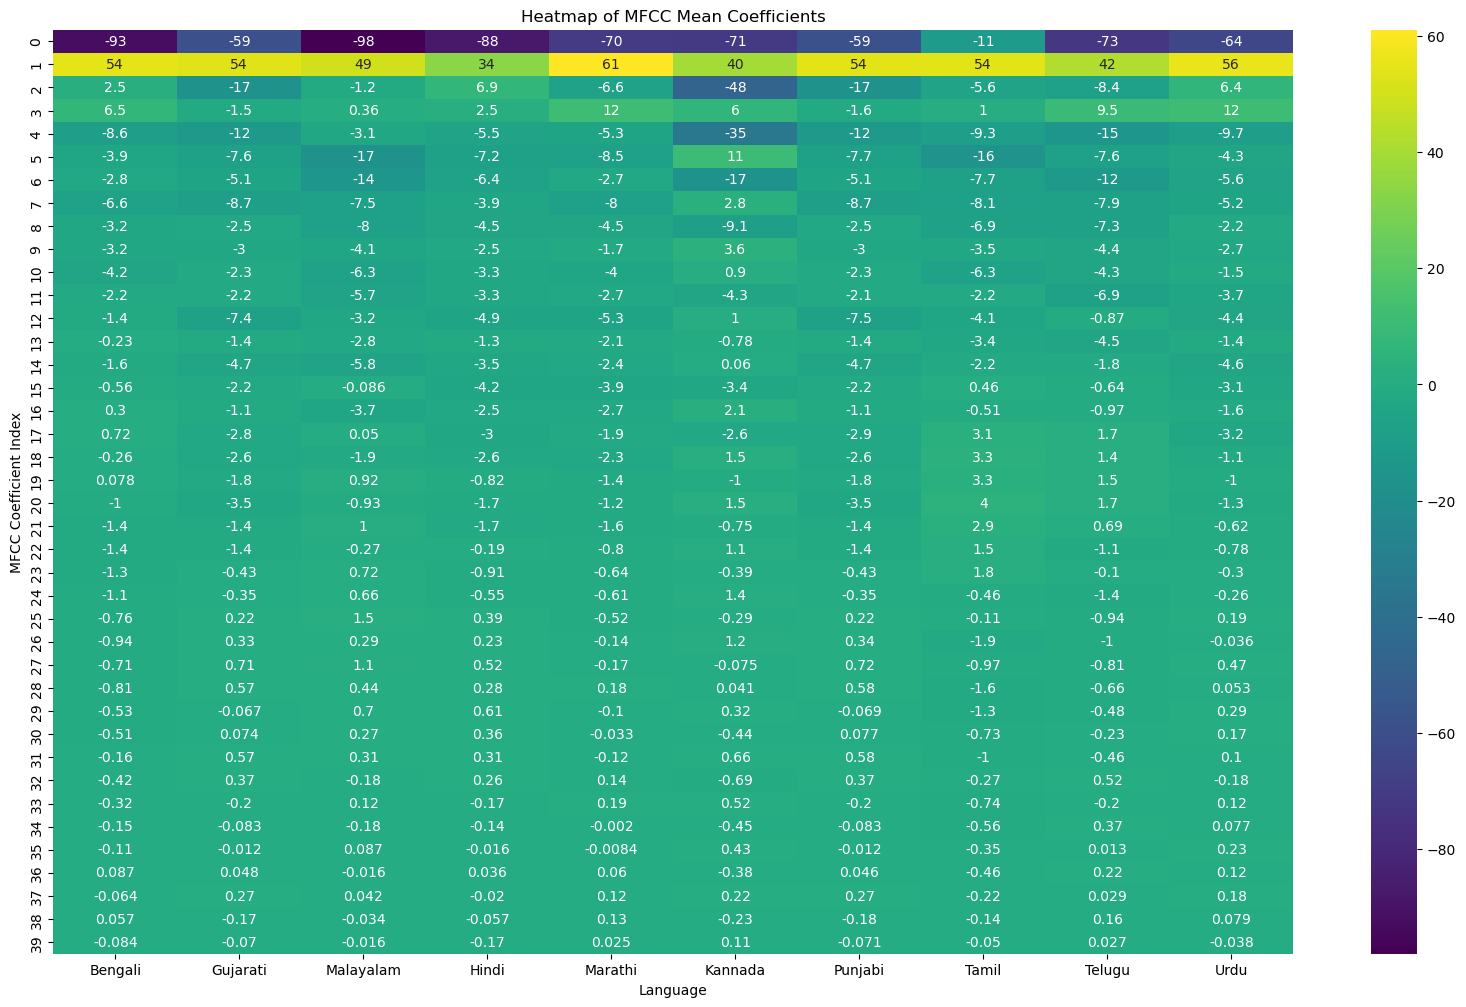

In [18]:
# 2. Heatmap of MFCC Mean Coefficients
# Create a DataFrame where rows are MFCC coefficient indices and columns are languages
df_means = pd.DataFrame({lang: stats[0] for lang, stats in analysis_stats.items()})
plt.figure(figsize=(20, 12))
sns.heatmap(df_means, annot=True, cmap='viridis')
plt.xlabel('Language')
plt.ylabel('MFCC Coefficient Index')
plt.title('Heatmap of MFCC Mean Coefficients')
plt.show()
plt.close()

In [19]:
# Compute and print statistics for each language
print("\nMFCC Statistics for Comparative Analysis:")
for language in LANGUAGES:
    mfccs = analysis_mfccs[language]
    if mfccs:
        mean, var = compute_statistics(mfccs)
        print(f"{language}:")
        print(f"  Mean per MFCC coefficient: {mean.numpy()}")
        print(f"  Variance per MFCC coefficient: {var.numpy()}\n")
    else:
        print(f"{language}: No valid files processed.\n")


MFCC Statistics for Comparative Analysis:
Bengali:
  Mean per MFCC coefficient: [-9.2874481e+01  5.4439774e+01  2.4733021e+00  6.5323839e+00
 -8.5961809e+00 -3.8774867e+00 -2.8224311e+00 -6.5583072e+00
 -3.1978626e+00 -3.2197638e+00 -4.2049174e+00 -2.1534736e+00
 -1.4490614e+00 -2.3443882e-01 -1.5782334e+00 -5.6197506e-01
  3.0063331e-01  7.1942794e-01 -2.6327854e-01  7.8248948e-02
 -1.0204920e+00 -1.3883870e+00 -1.4274487e+00 -1.2877005e+00
 -1.0777985e+00 -7.5626969e-01 -9.3967789e-01 -7.0687163e-01
 -8.1052119e-01 -5.3422600e-01 -5.1361710e-01 -1.5824886e-01
 -4.2388925e-01 -3.1570289e-01 -1.4930829e-01 -1.1286582e-01
  8.6639926e-02 -6.3929081e-02  5.7493765e-02 -8.3845913e-02]
  Variance per MFCC coefficient: [8.65857422e+03 1.19706958e+03 5.74367981e+02 3.87616241e+02
 2.86611481e+02 1.82991882e+02 1.21826057e+02 1.18461990e+02
 7.42259521e+01 6.67321091e+01 5.20306282e+01 5.59866180e+01
 5.83564224e+01 4.40790405e+01 6.85898056e+01 4.66118660e+01
 4.97867737e+01 5.81972160e+01 

In [20]:
# --- Data Preparation for Task B: Language Classification ---
print("Preparing data for classification...")
features = np.array(classification_features)  # (num_samples, n_mfcc)
labels = np.array(classification_labels) 

Preparing data for classification...


In [21]:
len(features), len(labels)

(256502, 256502)

In [22]:
# Normalize features (feature-wise normalization)
overall_mean = features.mean(axis=0)
overall_std = features.std(axis=0) + 1e-8
features = (features - overall_mean) / overall_std

In [23]:
# Manual train-test split (80% train, 20% test)
indices = list(range(len(features)))
random.shuffle(indices)
split_idx = int(0.8 * len(features))
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]
train_features = features[train_indices]
train_labels = labels[train_indices]
test_features = features[test_indices]
test_labels = labels[test_indices]

In [24]:
print("Train features:", len(train_features))
print("Train labels:", len(train_labels))

Train features: 205201
Train labels: 205201


In [25]:
# Further split training set into train and validation sets (80%-20%)
n_train = len(train_features)
split_val = int(0.8 * n_train)
train_feats_final = train_features[:split_val]
train_lbls_final = train_labels[:split_val]
val_feats = train_features[split_val:]
val_lbls = train_labels[split_val:]

In [26]:
# Create PyTorch Datasets
train_dataset = LanguageDataset(train_feats_final, train_lbls_final)
val_dataset = LanguageDataset(val_feats, val_lbls)
test_dataset = LanguageDataset(test_features, test_labels)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
input_dim = N_MFCC
num_classes = len(LANGUAGES)
model = MFCCClassifier(input_dim, hidden_dim, num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Candidate learning rate

In [29]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True, path='best_model.pt')
train_losses = []
val_losses = []

In [30]:
for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    train_loss = 0.0
    for features_batch, labels_batch in train_loader:
        features_batch = features_batch.to(device)
        labels_batch = labels_batch.to(device)
        optimizer.zero_grad()
        outputs = model(features_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features_batch, labels_batch in val_loader:
            features_batch = features_batch.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(features_batch)
            loss = criterion(outputs, labels_batch)
            val_loss += loss.item() * features_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Early Stopping Check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

Epoch 1/50, Training Loss: 0.9151, Validation Loss: 0.5166
Validation loss decreased. Saving model...
Epoch 2/50, Training Loss: 0.4375, Validation Loss: 0.3781
Validation loss decreased. Saving model...
Epoch 3/50, Training Loss: 0.3481, Validation Loss: 0.3229
Validation loss decreased. Saving model...
Epoch 4/50, Training Loss: 0.3053, Validation Loss: 0.2919
Validation loss decreased. Saving model...
Epoch 5/50, Training Loss: 0.2798, Validation Loss: 0.2724
Validation loss decreased. Saving model...
Epoch 6/50, Training Loss: 0.2627, Validation Loss: 0.2589
Validation loss decreased. Saving model...
Epoch 7/50, Training Loss: 0.2505, Validation Loss: 0.2486
Validation loss decreased. Saving model...
Epoch 8/50, Training Loss: 0.2412, Validation Loss: 0.2408
Validation loss decreased. Saving model...
Epoch 9/50, Training Loss: 0.2339, Validation Loss: 0.2343
Validation loss decreased. Saving model...
Epoch 10/50, Training Loss: 0.2278, Validation Loss: 0.2291
Validation loss decrea

In [31]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

C:\Users\aryan\AppData\Local\Temp\ipykernel_5036\898325533.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

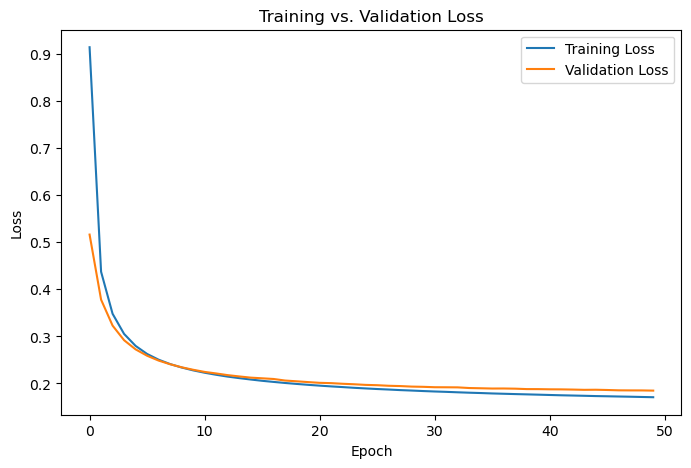

In [32]:
# Plot Training vs. Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

In [33]:
# Evaluate on Test Set
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for features_batch, labels_batch in test_loader:
        features_batch = features_batch.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(features_batch)
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())


In [34]:
accuracy = correct / total * 100
print(f"Final Test Accuracy: {accuracy:.2f}%")

Final Test Accuracy: 87.85%


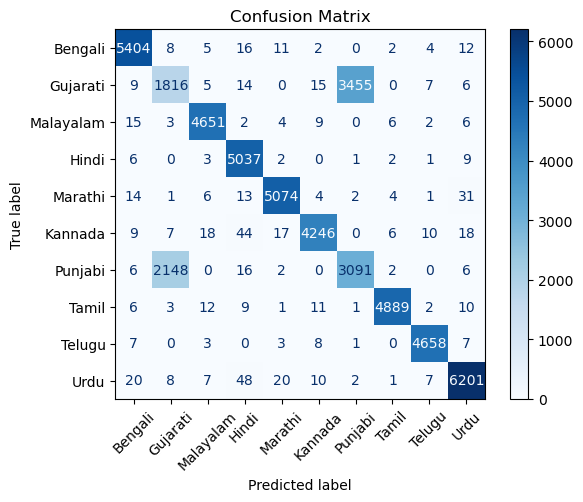

In [35]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LANGUAGES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()